In [ ]:
from google.colab import drive
drive.mount('drive')

!cp "drive/MyDrive/Datasets/GridGuid data/data_v2.zip" ./data_v2.zip
!unzip ./data_v2.zip

In [90]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

from tensorflow import keras
from keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import callbacks


In [105]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    './train_data/', image_size=(70, 70), batch_size=20, shuffle=True,
    color_mode='grayscale'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    './test_data/', image_size=(70, 70), batch_size=5, shuffle=False,
    color_mode='grayscale'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    './validation_data/', image_size=(70, 70), batch_size=3, shuffle=True,
    color_mode='grayscale'
)

Found 4504 files belonging to 10 classes.
Found 289 files belonging to 10 classes.
Found 108 files belonging to 10 classes.


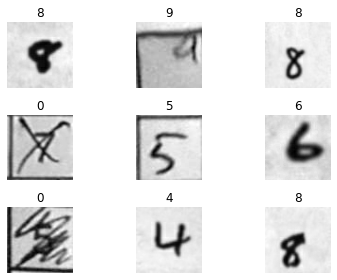

In [106]:
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(train_ds.class_names[labels[i]])
        plt.gray()
        plt.axis('off')

plt.tight_layout()
plt.show()


In [107]:
resize_and_rescale = tf.keras.Sequential([
    preprocessing.Resizing(70, 70),
    preprocessing.Rescaling(1.0/255.0)
])

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(10).prefetch(buffer_size=AUTOTUNE)


In [140]:
class CNNBlock(layers.Layer):
    def __init__(self, out_channels, dp_rate=.5, kernel_size=3):
        super(CNNBlock, self).__init__()
        self.dp_rate = dp_rate
        self.conv = layers.Conv2D(
            out_channels, kernel_size, padding='valid', use_bias=False
        )
        self.bn = layers.BatchNormalization()
        self.max_pool = layers.MaxPooling2D()

        if self.dp_rate != 0:
            self.dp = layers.Dropout(self.dp_rate)

    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.bn(x, training=training)
        x = self.max_pool(x)

        if self.dp_rate != 0:
            x = self.dp(x, training=training)

        x = tf.nn.relu(x)
        return x

model = keras.Sequential([
    keras.Input((70, 70, 1)),
    resize_and_rescale,
    CNNBlock(150, 0, 5),
    CNNBlock(100, .5, 4),
    CNNBlock(50, .3, 3),
    layers.Flatten(),
    layers.Dense(180, activation='relu'),
    layers.Dropout(.5),
    layers.Dense(45, activation='relu'),
    layers.Dense(10)
])

model.summary()


Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_29 (Sequential)  (None, 70, 70, 1)         0         
                                                                 
 cnn_block_158 (CNNBlock)    (None, 33, 33, 150)       4350      
                                                                 
 cnn_block_159 (CNNBlock)    (None, 15, 15, 100)       240400    
                                                                 
 cnn_block_160 (CNNBlock)    (None, 6, 6, 50)          45200     
                                                                 
 flatten_39 (Flatten)        (None, 1800)              0         
                                                                 
 dense_93 (Dense)            (None, 180)               324180    
                                                                 
 dropout_136 (Dropout)       (None, 180)             

In [141]:
initial_lr = 0.0001
n_epoch = 200
decay = 0.005 / n_epoch

lr_s = []

# time-based decay
def lr_time_based_decay(epoch, lr):
    lr_s.append(lr)
    return lr * 1 / (1 + decay * epoch)


callbacks_list = [
    callbacks.LearningRateScheduler(lr_time_based_decay, verbose=0),
    callbacks.EarlyStopping(
        monitor='loss', min_delta=1e-6, patience=10, verbose=1
    )
]


model.compile(
  optimizer=tf.keras.optimizers.Adam(initial_lr),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

train_log = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=n_epoch,
    callbacks=callbacks_list
)


Epoch 1/200
226/226 [==============================] - 9s 26ms/step - loss: 2.5670 - accuracy: 0.1250 - val_loss: 2.3068 - val_accuracy: 0.1019 - lr: 1.0000e-04
Epoch 2/200
226/226 [==============================] - 5s 24ms/step - loss: 2.3194 - accuracy: 0.1379 - val_loss: 2.2969 - val_accuracy: 0.1204 - lr: 9.9997e-05
Epoch 3/200
226/226 [==============================] - 5s 24ms/step - loss: 2.2554 - accuracy: 0.1718 - val_loss: 2.2043 - val_accuracy: 0.2130 - lr: 9.9992e-05
Epoch 4/200
226/226 [==============================] - 5s 24ms/step - loss: 2.1945 - accuracy: 0.1909 - val_loss: 2.1183 - val_accuracy: 0.2778 - lr: 9.9985e-05
Epoch 5/200
226/226 [==============================] - 5s 24ms/step - loss: 2.1323 - accuracy: 0.2200 - val_loss: 2.0538 - val_accuracy: 0.2685 - lr: 9.9975e-05
Epoch 6/200
226/226 [==============================] - 5s 24ms/step - loss: 2.0664 - accuracy: 0.2538 - val_loss: 2.0295 - val_accuracy: 0.3333 - lr: 9.9963e-05
Epoch 7/200
226/226 [=============

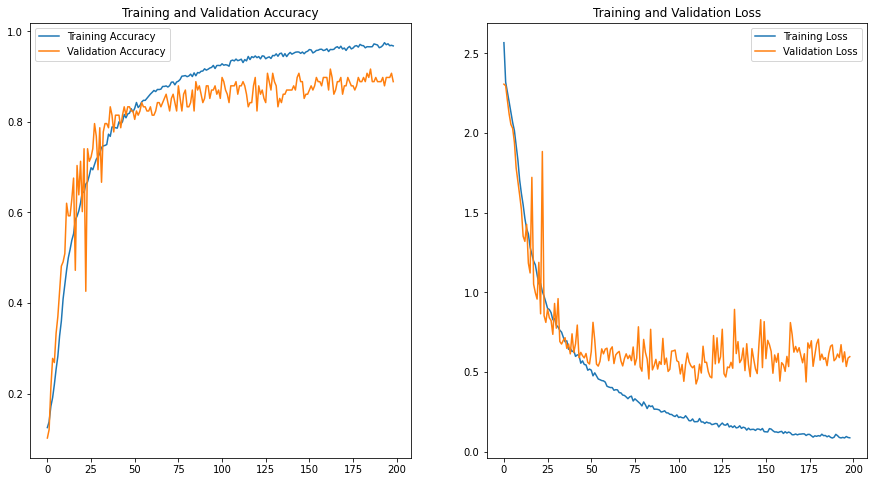

In [142]:
acc = train_log.history['accuracy']
val_acc = train_log.history['val_accuracy']
loss = train_log.history['loss']
val_loss = train_log.history['val_loss']

plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.plot(acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(122)
plt.plot(loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


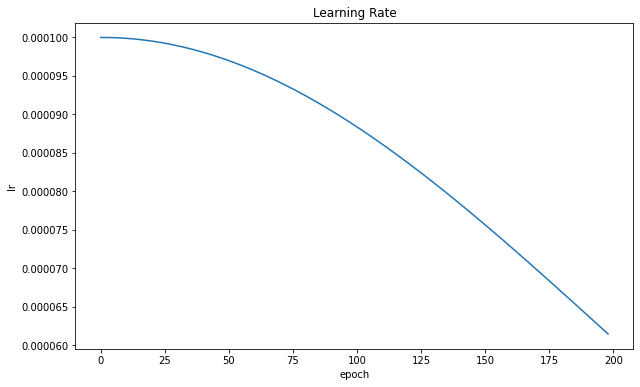

In [143]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(lr_s)), lr_s)
plt.title('Learning Rate')
plt.xlabel('epoch')
plt.ylabel('lr')
plt.show()


In [148]:
model.evaluate(test_ds)

58/58 [==============================] - 0s 5ms/step - loss: 0.5070 - accuracy: 0.8997


[0.506992518901825, 0.899653971195221]

1/1 [==============================] - 0s 29ms/step


<Figure size 720x288 with 0 Axes>

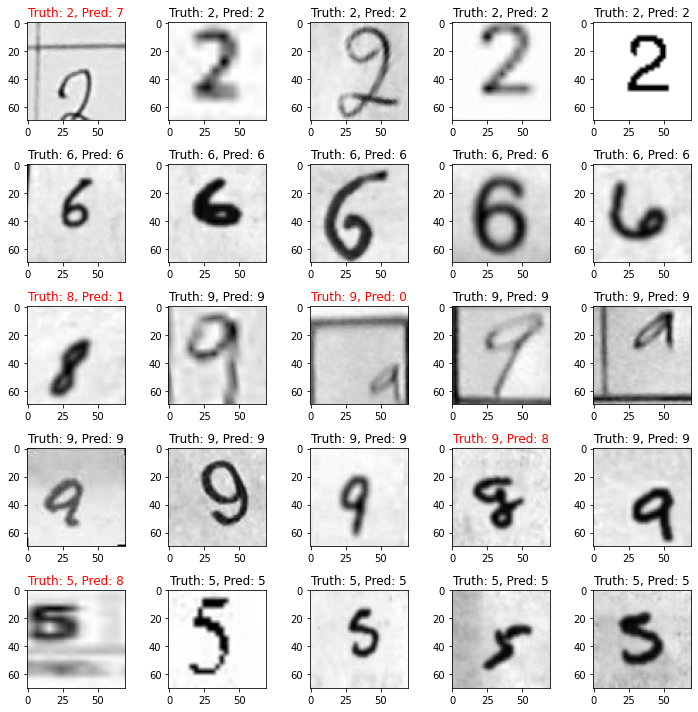

In [199]:
import numpy as np

class_names = list(range(10))

plt.figure(figsize=(10, 4))
plt.gray()

n_row = 5

fig, axes = plt.subplots(n_row, 5, figsize=(10, 10))

for row in range(n_row):
    for images_batch, labels_batch in test_ds.shuffle(100).take(1):
        preds = model.predict(images_batch)
        preds = np.argmax(preds, axis=1)
    
        for i in range(len(images_batch)):
            axes[row, i].imshow(images_batch[i].numpy().astype('uint8').reshape(70, 70))
            truth = labels_batch[i].numpy()
            pred = preds[i]
            axes[row, i].set_title(f"Truth: {truth}, Pred: {pred}", color='red' if truth != pred else 'black')


plt.tight_layout()
plt.show()

In [ ]:
_ = tf.keras.utils.image_dataset_from_directory(
    './test_data/', image_size=(70, 70), batch_size=5, shuffle=False,
    color_mode='grayscale'
)

y_preds = []
y_labels = []

for i in _:
    preds = model.predict(i[0])
    preds = np.argmax(preds, axis=1)
    labels = i[1].numpy()
    y_preds.append([*preds])
    y_labels.append([*labels])

y_preds_flatten = []
y_labels_flatten = []

for row in y_preds:
    for item in row:
        y_preds_flatten.append(item)

for row in y_labels:
    for item in row:
        y_labels_flatten.append(item)

y_preds_flatten = np.array(y_preds_flatten)
y_labels_flatten = np.array(y_labels_flatten)

In [243]:
cm = tf.math.confusion_matrix(labels=y_labels_flatten, predictions=y_preds_flatten)

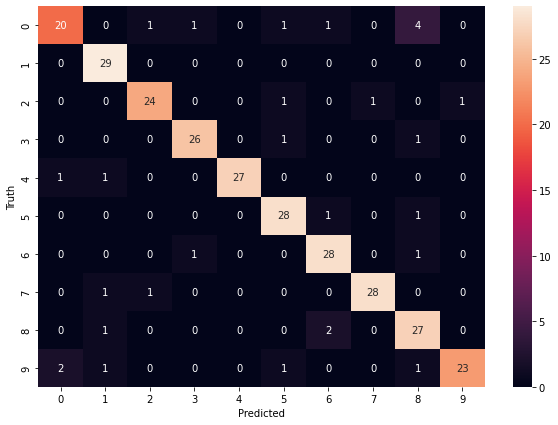

In [245]:
from seaborn import heatmap

plt.figure(figsize=(10,7))
heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [247]:
from sklearn import metrics
print(metrics.classification_report(y_labels_flatten, y_preds_flatten))

              precision    recall  f1-score   support

           0       0.87      0.71      0.78        28
           1       0.88      1.00      0.94        29
           2       0.92      0.89      0.91        27
           3       0.93      0.93      0.93        28
           4       1.00      0.93      0.96        29
           5       0.88      0.93      0.90        30
           6       0.88      0.93      0.90        30
           7       0.97      0.93      0.95        30
           8       0.77      0.90      0.83        30
           9       0.96      0.82      0.88        28

    accuracy                           0.90       289
   macro avg       0.90      0.90      0.90       289
weighted avg       0.90      0.90      0.90       289



In [251]:
model.save('./model_v2')

In [254]:
!zip -r ./model_v2.zip ./model_v2/*

  adding: model_v2/assets/ (stored 0%)
  adding: model_v2/fingerprint.pb (stored 0%)
  adding: model_v2/keras_metadata.pb (deflated 91%)
  adding: model_v2/saved_model.pb (deflated 89%)
  adding: model_v2/variables/ (stored 0%)
  adding: model_v2/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model_v2/variables/variables.index (deflated 65%)


In [255]:
converter = tf.lite.TFLiteConverter.from_saved_model('./model_v2')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
model_lite = converter.convert()

open('./model_v2.tflite', 'wb').write(model_lite)


1250640